In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import os
# Create a MirroredStrateg, If Multi-GPU available
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' 
tf.config.set_soft_device_placement(True)
# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2']) 
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from livelossplot.keras import PlotLossesCallback
from livelossplot import PlotLossesKerasTF
import efficientnet.keras as efn
import h5py, glob, re, cv2, math, matplotlib
import tensorflow.keras as keras
import pandas as pd
from pandas import read_csv
import numpy as np
from scipy import stats
import itertools, random

# from cnn_utils import *
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from PIL import Image  
import pdb
from statistics import mode 
from IPython.display import clear_output

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

np.random.seed(1)
# Setting the seed for python random numbers
random.seed(1254)
# Setting the graph-level random seed.
tf.random.set_seed(89)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
!CUDA_VISIBLE_DEVICES=2

# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2'])
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# def setup_multi_node_training(): # IMPORTANT: SET UP TF_CONFIG FOR MULTINODE TRAINING HERE os.environ[“TF_FORCE_GPU_ALLOW_GROWTH”] = “true” tf.config.set_soft_device_placement(True) mirrored_strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy(tf.distribute.experimental.CollectiveCommunication.NCCL) # Constructs the configuration run_config = tf.estimator.RunConfig( train_distribute=mirrored_strategy, ) return run_config
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Using TensorFlow backend.


Num GPUs Available:  1


## Load Data

In [2]:
filename = 'Datasets/All_subjects_RDmap.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
x_train1 = np.array(data["train_img"])
y_train1 = np.array(data["train_labels"])
x_test1 = np.array(data["test_img"])
y_test1 = np.array(data["test_labels"])
data.close()
print(x_train1.shape)
print(y_train1.shape)
print(x_test1.shape)
print(y_test1.shape)

Selected File: Datasets/All_subjects_RDmap.hdf5
(527, 605, 128, 128, 3)
(527, 605, 19)
(132, 605, 128, 128, 3)
(132, 605, 19)


In [3]:
filename = 'Datasets/All_subjects_RAmap.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
x_train2 = np.array(data["train_img"])
y_train2 = np.array(data["train_labels"])
x_test2 = np.array(data["test_img"])
y_test2 = np.array(data["test_labels"])
data.close()
print(x_train2.shape)
print(y_train2.shape)
print(x_test2.shape)
print(y_test2.shape)

Selected File: Datasets/All_subjects_RAmap.hdf5
(527, 605, 128, 128, 3)
(527, 605, 19)
(132, 605, 128, 128, 3)
(132, 605, 19)


In [4]:
# windowed RD
interval = range(0,600)
x_train11 = np.reshape(x_train1[:,interval,:,:,:], (x_train1.shape[0],120,5,x_train1.shape[2],x_train1.shape[3],x_train1.shape[4]))
x_test11 = np.reshape(x_test1[:,interval,:,:,:], (x_test1.shape[0],120,5,x_test1.shape[2],x_test1.shape[3],x_test1.shape[4]))
y_train11 = np.reshape(np.argmax(y_train1[:,interval,:],-1), (y_train1.shape[0],120,5))
y_test11 = np.reshape(np.argmax(y_test1[:,interval,:],-1), (y_test1.shape[0],120,5))
y_train11 = to_categorical(np.squeeze(stats.mode(y_train11,2)[0]))
y_test11 = to_categorical(np.squeeze(stats.mode(y_test11,2)[0]))
print(x_train11.shape)
print(y_train11.shape)
print(x_test11.shape)
print(y_test11.shape)  

# windowed RA
x_train12 = np.reshape(x_train2[:,interval,:,:,:], (x_train2.shape[0],120,5,x_train2.shape[2],x_train2.shape[3],x_train2.shape[4]))
x_test12 = np.reshape(x_test2[:,interval,:,:,:], (x_test2.shape[0],120,5,x_test2.shape[2],x_test2.shape[3],x_test2.shape[4]))
y_train12 = np.reshape(np.argmax(y_train2[:,interval,:],-1), (y_train2.shape[0],120,5))
y_test12 = np.reshape(np.argmax(y_test2[:,interval,:],-1), (y_test2.shape[0],120,5))
y_train12 = to_categorical(np.squeeze(stats.mode(y_train12,2)[0]))
y_test12 = to_categorical(np.squeeze(stats.mode(y_test12,2)[0]))
print(x_train12.shape)
print(y_train12.shape)
print(x_test12.shape)
print(y_test12.shape) 

(527, 120, 5, 128, 128, 3)
(527, 120, 19)
(132, 120, 5, 128, 128, 3)
(132, 120, 19)
(527, 120, 5, 128, 128, 3)
(527, 120, 19)
(132, 120, 5, 128, 128, 3)
(132, 120, 19)


In [5]:
filename = 'Datasets/All_subjects_spectrogram.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
x_train3 = np.array(data["train_img"])
y_train3 = np.array(data["train_labels"])
x_test3 = np.array(data["test_img"])
y_test3 = np.array(data["test_labels"])
data.close()
print(x_train3.shape)
print(y_train3.shape)
print(x_test3.shape)
print(y_test3.shape)

Selected File: Datasets/All_subjects_spectrogram.hdf5
(527, 120, 128, 128, 3)
(527, 120, 19)
(132, 120, 128, 128, 3)
(132, 120, 19)


In [6]:
filename = 'Datasets/All_subjects_margins_and_ctc_label.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
margin_tr = np.array(data["train_img"])
ctc_tr = np.squeeze(np.array(data["train_labels"])).astype('U12')
margin_ts = np.array(data["test_img"])
ctc_ts = np.squeeze(np.array(data["test_labels"])).astype('U12')
data.close()
print(margin_tr.shape)
print(ctc_tr.shape)
print(margin_ts.shape)
print(ctc_ts.shape)

Selected File: Datasets/All_subjects_margins_and_ctc_label.hdf5
(527, 1482)
(527,)
(132, 1482)
(132,)


##### STA LTA

In [7]:
def sta_lta2(vec,nlta,nsta,init_th,stop_th,stepsz):
    vec2 = np.zeros(vec.shape)
    mask = np.zeros(vec.shape)
    state = 0 # '0' nothing, '1' signing
    
    for i in range(0,len(vec),stepsz):
        
        if i+nlta+nsta+1 > len(vec):
            if state == 1:
                stoppt = len(vec)-2
                vec2[startpt:stoppt] = vec[startpt:stoppt]
                mask[startpt:stoppt] = 1
            break
            
            
        longwin = vec[i:i+nlta]
        shortwin = vec[i+nlta:i+nlta+nsta]
        
        if i < nlta and np.mean(longwin) > 150:
            vec2[0:i+nsta] = vec[0:i+nsta]
            mask[0:i+nsta] = 1
        if init_th < sum(shortwin)/sum(longwin):
            if state == 0:
                startpt = i+nlta
                state = 1
            if state == 1:
                continue
        
        else:
            if state == 0:
                continue
            if state == 1:
                if sum(shortwin)/sum(longwin) > stop_th:
                    continue
                else:
                    stoppt = i+nlta+int(nsta/2)
                    state = 0
                    vec2[startpt:stoppt] = vec[startpt:stoppt]
                    mask[startpt:stoppt] = 1
                    
    return vec2, mask

In [8]:
duration = 24.2
nsta_sec = 0.7
ratio = margin_tr.shape[-1]/duration
nsta = int(nsta_sec*ratio)
nlta = int(2*nsta)
stepsz = int(0.2*ratio) # 0.2
timevec = np.linspace(0,24.2,margin_ts.shape[1])
idx = 27
init_th = 0.6
stop_th = 0.3
vecs_train = [] #np.zeros(np.argmax(margin_tr,-1).shape)
mask_train = [] #np.zeros(np.argmax(margin_tr,-1).shape)
vecs_test = [] #np.zeros(np.argmax(margin_ts,-1).shape)
mask_test = [] #np.zeros(np.argmax(margin_ts,-1).shape)
for i in range(len(margin_tr)):
    vecs_train.append(sta_lta2(margin_tr[i],nlta,nsta,init_th,stop_th,stepsz)[0])
    mask_train.append(sta_lta2(margin_tr[i],nlta,nsta,init_th,stop_th,stepsz)[1])
# mask_train_win = mask_train[:,::5]
for i in range(len(margin_ts)):
    vecs_test.append(sta_lta2(margin_ts[i],nlta,nsta,init_th,stop_th,stepsz)[0])
    mask_test.append(sta_lta2(margin_ts[i],nlta,nsta,init_th,stop_th,stepsz)[1])
# mask_test_win = mask_test[:,::5]
mask_train = np.array(mask_train)
mask_test = np.array(mask_test)

In [9]:
# downsample the mask to vid
mask_vid_tr = np.zeros(np.argmax(y_train1,-1).shape)
ratio1 = mask_train.shape[-1]/mask_vid_tr.shape[-1]
for i in range(len(mask_train)):
    for j in range(mask_train.shape[-1]):
        if mask_train[i,j] == 0:
            continue
        else:
            mask_vid_tr[i,int(j/ratio1)] = 1
mask_vid_ts = np.zeros(np.argmax(y_test1,-1).shape)
for i in range(len(mask_test)):
    for j in range(mask_test.shape[-1]):
        if mask_test[i,j] == 0:
            continue
        else:
            mask_vid_ts[i,int(j/ratio1)] = 1

# downsample the mask to spect
mask_spect_tr = np.zeros(np.argmax(y_train3,-1).shape)
ratio2 = mask_train.shape[-1]/mask_spect_tr.shape[-1]
for i in range(len(mask_train)):
    for j in range(mask_train.shape[-1]):
        if mask_train[i,j] == 0:
            continue
        else:
            mask_spect_tr[i,int(j/ratio2)] = 1
mask_spect_ts = np.zeros(np.argmax(y_test3,-1).shape)
for i in range(len(mask_test)):
    for j in range(mask_test.shape[-1]):
        if mask_test[i,j] == 0:
            continue
        else:
            mask_spect_ts[i,int(j/ratio2)] = 1
print('Mask shapes:')
print(mask_vid_tr.shape)
print(mask_vid_ts.shape)
print(mask_spect_tr.shape)
print(mask_spect_ts.shape)

Mask shapes:
(527, 605)
(132, 605)
(527, 120)
(132, 120)


In [10]:
num_class = y_test3.shape[2]
num_class

19

In [11]:
# Mask reshaped RD
x1train = []
y1train = []
flag = 0
for i in range(len(mask_spect_tr)):
    for j in range(mask_spect_tr.shape[1]):
        if mask_spect_tr[i,j] == 0:
            if flag == 0:
                continue
            else:
                stoppt = j
                if stoppt-startpt>2:
                    x1train.append(x_train11[i,startpt:stoppt])
                    y1train.append(np.squeeze(np.argmax(y_train3[i,startpt:stoppt],-1)))
                    flag = 0
        else:
            if flag == 0:
                startpt = j
                flag = 1
            else:
                continue
x1train = np.asarray(x1train)
y1train = np.array([to_categorical(y,num_classes=num_class) for y in np.array(y1train)])
x1test = []
y1test = []
flag = 0
for i in range(len(mask_spect_ts)):
    for j in range(mask_spect_ts.shape[1]):
        if mask_spect_ts[i,j] == 0:
            if flag == 0:
                continue
            else:
                stoppt = j
                if stoppt-startpt>2:
                    x1test.append(x_test11[i,startpt:stoppt])
                    y1test.append(np.squeeze(np.argmax(y_test3[i,startpt:stoppt],-1)))
                    flag = 0
        else:
            if flag == 0:
                startpt = j
                flag = 1
            else:
                continue
x1test = np.asarray(x1test)
y1test = np.array([to_categorical(y,num_classes=num_class) for y in np.array(y1test)])
print(x1train.shape)
print(y1train.shape)
print(x1test.shape)
print(y1test.shape)

(1154,)
(1154,)
(272,)
(272,)


In [12]:
# Mask reshaped RA
x2train = []
y2train = []
flag = 0
for i in range(len(mask_spect_tr)):
    for j in range(mask_spect_tr.shape[1]):
        if mask_spect_tr[i,j] == 0:
            if flag == 0:
                continue
            else:
                stoppt = j
                if stoppt-startpt>2:
                    x2train.append(x_train12[i,startpt:stoppt])
                    y2train.append(np.squeeze(np.argmax(y_train3[i,startpt:stoppt],-1)))
                    flag = 0
        else:
            if flag == 0:
                startpt = j
                flag = 1
            else:
                continue
x2train = np.asarray(x2train)
y2train = np.array([to_categorical(y,num_classes=num_class) for y in np.array(y2train)])
x2test = []
y2test = []
flag = 0
for i in range(len(mask_spect_ts)):
    for j in range(mask_spect_ts.shape[1]):
        if mask_spect_ts[i,j] == 0:
            if flag == 0:
                continue
            else:
                stoppt = j
                if stoppt-startpt>2:
                    x2test.append(x_test12[i,startpt:stoppt])
                    y2test.append(np.squeeze(np.argmax(y_test3[i,startpt:stoppt],-1)))
                    flag = 0
        else:
            if flag == 0:
                startpt = j
                flag = 1
            else:
                continue
x2test = np.asarray(x2test)
y2test = np.array([to_categorical(y,num_classes=num_class) for y in np.array(y2test)])
print(x2train.shape)
print(y2train.shape)
print(x2test.shape)
print(y2test.shape)

(1154,)
(1154,)
(272,)
(272,)


In [13]:
# Mask reshaped mD
x3train = []
y3train = []
flag = 0
for i in range(len(mask_spect_tr)):
    for j in range(mask_spect_tr.shape[1]):
        if mask_spect_tr[i,j] == 0:
            if flag == 0:
                continue
            else:
                stoppt = j
                if stoppt-startpt>2:
                    x3train.append(x_train3[i,startpt:stoppt])
                    y3train.append(np.squeeze(np.argmax(y_train3[i,startpt:stoppt],-1)))
                    flag = 0
        else:
            if flag == 0:
                startpt = j
                flag = 1
            else:
                continue
x3train = np.asarray(x3train)
y3train = np.array([to_categorical(y,num_classes=num_class) for y in np.array(y3train)])
x3test = []
y3test = []
flag = 0
for i in range(len(mask_spect_ts)):
    for j in range(mask_spect_ts.shape[1]):
        if mask_spect_ts[i,j] == 0:
            if flag == 0:
                continue
            else:
                stoppt = j
                if stoppt-startpt>2:
                    x3test.append(x_test3[i,startpt:stoppt])
                    y3test.append(np.squeeze(np.argmax(y_test3[i,startpt:stoppt],-1)))
                    flag = 0
        else:
            if flag == 0:
                startpt = j
                flag = 1
            else:
                continue
x3test = np.asarray(x3test)
y3test = np.array([to_categorical(y,num_classes=num_class) for y in np.array(y3test)])
print(x3train.shape)
print(y3train.shape)
print(x3test.shape)
print(y3test.shape)

(1154,)
(1154,)
(272,)
(272,)


# Import model & test

In [14]:
model_addr = 'Models/td3d-bilstm 19 class GD fbf reshaped rd.json'
weight_addr = 'Models/td3d-bilstm 19 class GD fbf reshaped rd.h5'
json_file = open(model_addr, 'r')
loaded_model_json = json_file.read()
json_file.close()
model_rd = model_from_json(loaded_model_json)
model_rd.load_weights(weight_addr)

model_addr = 'Models/td3d-bilstm 19 class GD fbf reshaped ra.json'
weight_addr = 'Models/td3d-bilstm 19 class GD fbf reshaped ra.h5'
json_file = open(model_addr, 'r')
loaded_model_json = json_file.read()
json_file.close()
model_ra = model_from_json(loaded_model_json)
model_ra.load_weights(weight_addr)

model_addr = 'Models/td2d-bilstm 19 class GD fbf seq mD.json'
weight_addr = 'Models/td2d-bilstm 19 class GD fbf seq mD.h5'
json_file = open(model_addr, 'r')
loaded_model_json = json_file.read()
json_file.close()
model_md = model_from_json(loaded_model_json)
model_md.load_weights(weight_addr)

In [77]:
# RD test
pred = [np.argmax(np.squeeze(model_rd.predict(np.expand_dims(x1test[i],0))),-1) for i in range(0,x1test.shape[0])]
# pred = model_fus.predict(pred_gen, batch_size = 1, steps = len(x3test))
Y_pred = np.concatenate(pred)
Y_test_int = np.concatenate([np.argmax(y, -1) for y in y3test])
cmp = Y_pred == Y_test_int
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

73.72881355932203

In [108]:
# RA test
pred = [np.argmax(np.squeeze(model_ra.predict(np.expand_dims(x2test[i],0))),-1) for i in range(0,x2test.shape[0])]
# pred = model_fus.predict(pred_gen, batch_size = 1, steps = len(x3test))
Y_pred = np.concatenate(pred)
Y_test_int = np.concatenate([np.argmax(y, -1) for y in y3test])
cmp = Y_pred == Y_test_int
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

69.05412793876435

In [110]:
# mD test
pred = [np.argmax(np.squeeze(model_md.predict(np.expand_dims(x3test[i],0))),-1) for i in range(0,x3test.shape[0])]
# pred = model_fus.predict(pred_gen, batch_size = 1, steps = len(x3test))
Y_pred = np.concatenate(pred)
Y_test_int = np.concatenate([np.argmax(y, -1) for y in y3test])
cmp = Y_pred == Y_test_int
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

76.70858392564243

In [126]:
def data_generator_multi(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = np.array(data[0]).shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            label = labels[offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            y_train = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                y_train.append(label[i])

            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)

            # yield the next training batch            
            yield [X_train1, X_train2, X_train3], y_train
#             yield [X_train1, X_train2], y_train
#             yield [np.expand_dims(X_train1[i],0),np.expand_dims(X_train2[i],0),np.expand_dims(X_train3[i],0)], y_train

In [127]:
datax = [x1train, x2train, x3train]
num_samples = np.array(datax[0]).shape[0]
num_samples

1154

In [128]:
train_generator = data_generator_multi([x1train, x2train, x3train], y3train)
test_generator = data_generator_multi([x1test, x2test, x3test], y3test)
# train_generator = data_generator_multi([x1train, x2train], y3train)
# test_generator = data_generator_multi([x1test, x2test], y3test)

# Multi-input Classification

In [136]:
merged_layers = concatenate([model_rd.layers[-2].output, model_ra.layers[-2].output, model_md.layers[-2].output],-1)
out1 = TimeDistributed(Dense(num_class,activation='softmax'))(merged_layers)
opt = Adam(lr=1e-3, decay=1e-3 / 200)
mod_fus = keras.Model(inputs = [model_rd.input,model_ra.input,model_md.input],outputs = out1)
mod_fus.compile(loss = 'categorical_crossentropy', optimizer=opt,metrics = ['accuracy'])
# mod_fus.summary()

# merged_layers = concatenate([model_rd.layers[-2].output, model_ra.layers[-2].output],-1)
# out1 = TimeDistributed(Dense(num_class,activation='softmax'))(merged_layers)
# opt = Adam(lr=1e-3, decay=1e-3 / 200)
# mod_fus = keras.Model(inputs = [model_rd.input, model_ra.input],outputs = out1)
# mod_fus.compile(loss = 'categorical_crossentropy', optimizer=opt,metrics = ['accuracy'])
# mod_fus.summary()

In [130]:
# Freeze the layers except the last 7 layers
for layer in mod_fus.layers[:-2]:
    layer.trainable = False

# Check the trainable status of the individual layers
# for layer in mod_fus.layers:
#     print(layer, layer.trainable)

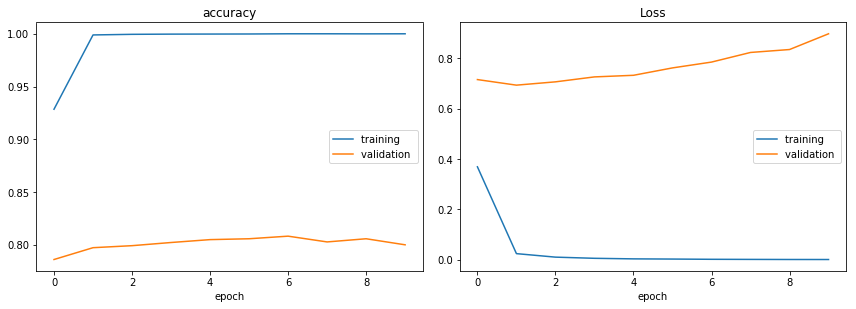

accuracy
	training         	 (min:    0.889, max:    1.000, cur:    1.000)
	validation       	 (min:    0.786, max:    0.952, cur:    0.800)
Loss
	training         	 (min:    0.000, max:    0.503, cur:    0.001)
	validation       	 (min:    0.197, max:    0.897, cur:    0.897)
1154/1154 [==============================] - 23s 20ms/step - loss: 5.7594e-04 - accuracy: 1.0000 - val_loss: 0.8968 - val_accuracy: 0.7999


In [137]:
history = mod_fus.fit(train_generator, validation_data=test_generator,
                        epochs=10, batch_size=1, steps_per_epoch = len(x1train), validation_steps = len(x1test),
                        shuffle=False, callbacks = [PlotLossesKerasTF()], 
                        verbose=1)
# history = mod_fus.fit(train_generator, validation_data=([np.expand_dims(x1test[i],0),np.expand_dims(x2test[i],0),np.expand_dims(x3test[i],0)],np.expand_dims(y3test[i],0)),
#                         epochs=10, batch_size=1, steps_per_epoch = len(x1train), validation_steps = len(x1test),
#                         shuffle=False, callbacks = [PlotLossesKerasTF()], 
#                         verbose=1)

In [138]:
pred = [np.argmax(np.squeeze(mod_fus.predict([np.expand_dims(x1test[i],0), np.expand_dims(x2test[i],0), np.expand_dims(x3test[i],0)])),-1) for i in range(0,y3test.shape[0])]
Y_pred = np.concatenate(pred)
Y_test_int = np.concatenate([np.argmax(y, -1) for y in y3test])
cmp = Y_pred == Y_test_int
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

79.98906506287588

In [139]:
evalu = mod_fus.evaluate_generator(test_generator)
print(model11.metrics_names)
print(evalu)

KeyboardInterrupt: 

In [ ]:
# save model
MODEL_FILE = "Models/gd fusion.json" # save path
WEIGHT_FILE ="Models/gd fusion.h5" # save path

model_json = mod_fus.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
mod_fus.save_weights(WEIGHT_FILE)

# Import model & test

In [15]:
model_addr = 'Models/gd fusion.json'
weight_addr = 'Models/gd fusion.h5'
json_file = open(model_addr, 'r')
loaded_model_json = json_file.read()
json_file.close()
model_fus = model_from_json(loaded_model_json)
model_fus.load_weights(weight_addr)

In [140]:
# for layer in model_fus.layers:
#     print(layer.output_shape)
#     print(layer.name)

/home/m/.local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


<function matplotlib.pyplot.show(*args, **kw)>

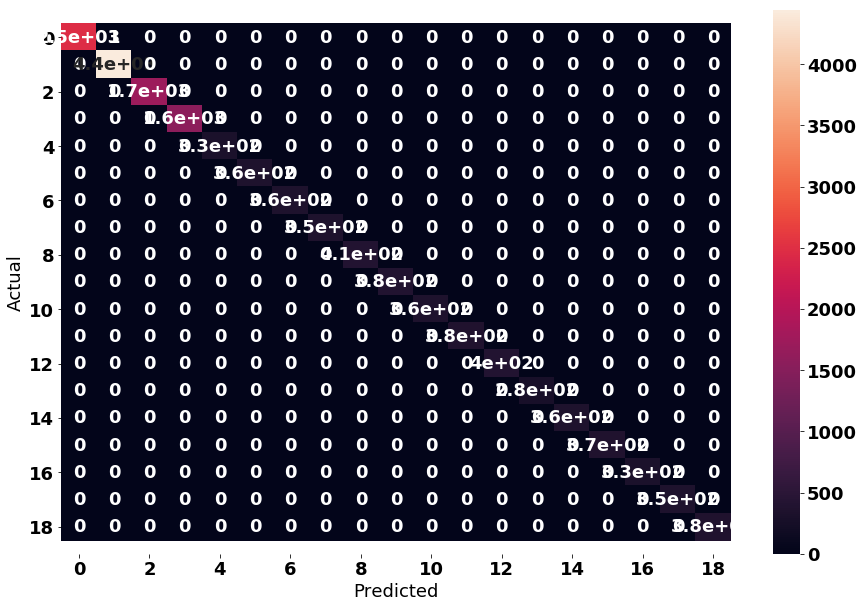

In [141]:
import pandas as pd
import seaborn as sn
# %matplotlib qt 
# opens figure in a new window
font = {'family' : 'normal', 
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font) 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18) 

# pred = np.zeros(y3train.shape)
# for i in range(0,x3test.shape[0]):
# pred = [np.argmax(np.squeeze(mod_fus.predict([np.expand_dims(x1train[i],0),np.expand_dims(x2train[i],0),np.expand_dims(x3train[i],0)])),-1) for i in range(0,x3train.shape[0])]
pred = [np.argmax(np.squeeze(mod_fus.predict([np.expand_dims(x1test[i],0), np.expand_dims(x2test[i],0), np.expand_dims(x3test[i],0)])),-1) for i in range(0,x1test.shape[0])]
# pred = model_fus.predict(pred_gen, batch_size = 1, steps = len(x3test))
Y_pred = np.concatenate(pred)
Y_test_int = np.concatenate([np.argmax(y, -1) for y in y3test])
#print(predictions[0:5])
#print(Y_pred[0:5])
#print(Y_test_int[0:5])
data = {'y_Predicted': Y_pred,
        'y_Actual':    Y_test_int
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = False)
fig3 = plt.figure()
sn.heatmap(confusion_matrix, annot=True)
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b,t)
fig3.set_size_inches(15,10)
plt.show

In [142]:
cmp = Y_pred == Y_test_int
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

99.99357821731313

# Multi-input from scratch

In [143]:
def multi_mod():
    with tf.device('/gpu:2'):
        
        inputlayer1 = Input(shape = input_shape1)
        y = TimeDistributed(Conv3D(8, kernel_size=(3, 3, 3), padding='same', activation='relu'))(inputlayer1)
        y = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(y)
        y = TimeDistributed(Conv3D(16, kernel_size=(3, 3, 3), padding='same', activation='relu'))(y)
        y = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(y)
        y = TimeDistributed(Conv3D(32, kernel_size=(3, 3, 3), padding='same', activation='relu'))(y)
        y = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(y)
        y = TimeDistributed(Flatten())(y)
        y = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(y)
        
        inputlayer2 = Input(shape = input_shape2)
        z = TimeDistributed(Conv3D(8, kernel_size=(3, 3, 3), padding='same', activation='relu'))(inputlayer2)
        z = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(z)
        z = TimeDistributed(Conv3D(16, kernel_size=(3, 3, 3), padding='same', activation='relu'))(z)
        z = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(z)
        z = TimeDistributed(Conv3D(32, kernel_size=(3, 3, 3), padding='same', activation='relu'))(z)
        z = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(z)
        z = TimeDistributed(Flatten())(z)
        z = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(z)
        
        inputlayer3 = Input(shape = input_shape3)
        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer3)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Flatten())(x)
        x = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(x)
        
        cat = concatenate([y,z,x])
        out = TimeDistributed(Dense(num_class,activation='softmax'))(cat)
        
        model = keras.Model(inputs = [inputlayer1,inputlayer2,inputlayer3], outputs = [out])#, out2, out3])
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        model.compile(loss = 'categorical_crossentropy', optimizer=opt,metrics = ['accuracy'],sample_weight_mode="temporal")
        
        return model 

In [144]:
input_shape1 = (None,x1train[0].shape[1],x1train[0].shape[2],x1train[0].shape[3],x1train[0].shape[4])
input_shape2 = input_shape1
input_shape3 = (None,x3train[0].shape[1],x3train[0].shape[2],x3train[0].shape[3])

In [145]:
model11 = multi_mod()

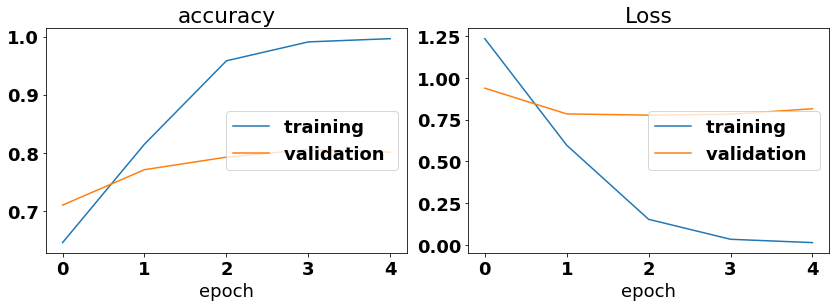

accuracy
	training         	 (min:    0.645, max:    1.000, cur:    0.996)
	validation       	 (min:    0.710, max:    0.952, cur:    0.801)
Loss
	training         	 (min:    0.000, max:    1.235, cur:    0.014)
	validation       	 (min:    0.197, max:    0.938, cur:    0.815)
1154/1154 [==============================] - 71s 61ms/step - loss: 0.0139 - accuracy: 0.9965 - val_loss: 0.8151 - val_accuracy: 0.8010


In [146]:
history = model11.fit_generator(train_generator,validation_data = test_generator,
                        epochs=5, #batch_size=1, 
                        steps_per_epoch = len(x1train), validation_steps = len(x1test), 
                        shuffle=False, callbacks = [PlotLossesKerasTF()], 
                        verbose=1)

In [147]:
pred = [np.argmax(np.squeeze(model11.predict([np.expand_dims(x1test[i],0), np.expand_dims(x2test[i],0), np.expand_dims(x3test[i],0)])),-1) for i in range(0,y3test.shape[0])]
Y_pred = np.concatenate(pred)
Y_test_int = np.concatenate([np.argmax(y, -1) for y in y3test])
cmp = Y_pred == Y_test_int
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

80.098414434117

In [148]:
# save model
MODEL_FILE = "Models/gd fusion.json" # save path
WEIGHT_FILE ="Models/gd fusion.h5" # save path

model_json = mod_fus.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
mod_fus.save_weights(WEIGHT_FILE)